# Advanced Housing Dataset Exploration
1.  Introduction
2.  Exploring the Data
3.  Plotting the Data
4.  Training the Model

# Introduction


Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn, and scikit-learn to improve my data analysis and visualization skills. I know this analysis is rather simplistic and makes some arbitrary selections. But I'm primarily focusing on my competence with these libraries, not so much on the optimal data science procedures.

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Univariate
  2. Lasso (L1)
  3. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_columns = None
pd.options.display.max_rows = 40

housing = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [2]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

In [3]:
# # Scatter Plots for all features vs target

# for feature in train.columns:
#     if feature != 'SalePrice':
#         plt.figure(figsize = (1, 1))
#         sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
#         plt.title(f'Sale Price vs {feature}')
#         plt.show()

In [4]:
# # Let's try to do regression only for numerical features vs target

# count = 0

# for feature in train.columns:
#     if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
#         count += 1
#         plt.figure(figsize = (1, 1))
#         plt.title(f'Sale Price vs {feature}')
#         sns.regplot(x = feature, y = 'SalePrice', data = train)
#         plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

In [5]:
display(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
113,114,20,RL,NaN,21000,Pave,NaN,Reg,Bnk,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,5,1953,1953,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,184.0,TA,Gd,CBlock,Gd,TA,Mn,ALQ,35,Rec,869,905,1809,GasA,TA,Y,SBrkr,2259,0,0,2259,1,0,2,0,3,1,Gd,7,Typ,2,Gd,Basment,1953.0,Unf,2,450,TA,TA,Y,166,120,192,0,0,0,NaN,MnPrv,NaN,0,10,2007,COD,Abnorml,217000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
228,229,20,RL,70.0,8521,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,5,1967,1967,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,842,Unf,0,70,912,GasA,TA,Y,SBrkr,912,0,0,912,0,0,1,0,3,1,TA,5,Typ,1,Fa,Detchd,1974.0,Unf,1,336,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,125000
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
859,860,60,RL,NaN,11029,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosA,Norm,1Fam,2Story,6,7,1968,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,220.0,TA,TA,CBlock,TA,TA,Mn,BLQ,619,Unf,0,435,1054,GasA,TA,Y,SBrkr,1512,1142,0,2654,1,0,2,1,4,1,Gd,9,Typ,1,Gd,Attchd,1968.0,Unf,2,619,TA,TA,Y,0,65,0,0,222,0,NaN,NaN,NaN,0,8,2006,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,45,RL,55.0,5500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Unf,4,6,1956,1956,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,882,882,GasA,Ex,Y,SBrkr,882,0,0,882,0,0,1,0,1,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2007,WD,Normal,103200
1001,1002,30,RL,60.0,5400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0,Unf,0,691,691,GasA,Ex,Y,FuseA,691,0,0,691,0,0,1,0,2,1,Ex,4,Typ,0,NaN,Detchd,1920.0,Unf,1,216,Fa,TA,N,0,20,94,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Abnorml,86000
567,568,20,RL,70.0,10171,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,168.0,Gd,TA,PConc,Gd,TA,No,GLQ,2,Unf,0,1515,1517,GasA,Ex,Y,SBrkr,1535,0,0,1535,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2004.0,RFn,2,532,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,214000
23,24,120,RM,44.0,4224,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,1Story,5,7,1976,1976,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,840,Unf,0,200,1040,Gas

In [6]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,971.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1163.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1104.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,720.762842,57.568493,69.832132,10433.763699,6.067637,5.540240,1971.329623,1984.782534,103.337059,436.427226,44.707192,575.833904,1056.968322,1164.056507,343.307363,6.566781,1513.930651,0.429795,0.053938,1.565068,0.377568,2.851027,1.048801,6.507705,0.601884,1978.584239,1.767979,474.069349,93.933219,46.500000,21.956336,3.797945,14.699486,1.925514,43.904110,6.323630,2007.785959,179426.580479
std,424.966100,42.748287,23.149706,9892.826542,1.371661,1.084323,30.379351,20.719963,185.843168,460.737801,159.387995,444.191894,442.567228,386.470710,431.951488,51.921574,526.062020,0.525480,0.233453,0.548469,0.504047,0.834187,0.227158,1.638214,0.635885,24.670855,0.738303,213.258627,124.548696,66.159606,61.525820,31.441085,55.958345,33.404618,540.916894,2.688588,1.326834,76947.655112
min,3.000000,20.000000,21.000000,1526.000000,1.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,351.750000,20.000000,59.000000,7538.750000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,228.000000,795.750000,884.000000,0.000000,0.000000,1125.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,716.500000,50.000000,68.000000,9351.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,375.000000,0.000000,490.000000,992.500000,1088.500000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.500000,2.000000,480.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,161250.000000
75%,1089.500000,70.000000,80.000000,11446.500000,7.000000,6.000000,2001.000000,2004.000000,161.500000,709.000000,0.000000,813.250000,1293.750000,1382.000000,728.000000,0.000000,1780.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,211250.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2009.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,1872.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [8]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     197
Alley          1093
FireplaceQu     557
PoolQC         1164
Fence           947
MiscFeature    1131
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,LotFrontage,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
113,NaN,NaN,Gd,NaN,MnPrv,NaN
7,NaN,NaN,TA,NaN,NaN,Shed
228,70.0,NaN,Fa,NaN,MnPrv,NaN
650,65.0,NaN,NaN,NaN,NaN,NaN
859,NaN,NaN,Gd,NaN,NaN,NaN
...,...,...,...,...,...,...
163,55.0,NaN,NaN,NaN,MnPrv,NaN
1001,60.0,NaN,NaN,NaN,NaN,NaN
567,70.0,NaN,NaN,NaN,NaN,NaN
23,44.0,NaN,TA,NaN,NaN,NaN


All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [9]:
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
113,114,20,RL,21000,Pave,Reg,Bnk,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,5,1953,1953,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,184.0,TA,Gd,CBlock,Gd,TA,Mn,ALQ,35,Rec,869,905,1809,GasA,TA,Y,SBrkr,2259,0,0,2259,1,0,2,0,3,1,Gd,7,Typ,2,Basment,1953.0,Unf,2,450,TA,TA,Y,166,120,192,0,0,0,0,10,2007,COD,Abnorml,217000
7,8,60,RL,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
228,229,20,RL,8521,Pave,Reg,Lvl,AllPub,FR2,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,5,1967,1967,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,842,Unf,0,70,912,GasA,TA,Y,SBrkr,912,0,0,912,0,0,1,0,3,1,TA,5,Typ,1,Detchd,1974.0,Unf,1,336,TA,TA,Y,0,0,0,0,0,0,0,5,2010,WD,Normal,125000
650,651,60,FV,8125,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,0,5,2008,WD,Normal,205950
859,860,60,RL,11029,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosA,Norm,1Fam,2Story,6,7,1968,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,220.0,TA,TA,CBlock,TA,TA,Mn,BLQ,619,Unf,0,435,1054,GasA,TA,Y,SBrkr,1512,1142,0,2654,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,1968.0,Unf,2,619,TA,TA,Y,0,65,0,0,222,0,0,8,2006,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,45,RL,5500,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Unf,4,6,1956,1956,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,882,882,GasA,Ex,Y,SBrkr,882,0,0,882,0,0,1,0,1,1,TA,4,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,0,4,2007,WD,Normal,103200
1001,1002,30,RL,5400,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0,Unf,0,691,691,GasA,Ex,Y,FuseA,691,0,0,691,0,0,1,0,2,1,Ex,4,Typ,0,Detchd,1920.0,Unf,1,216,Fa,TA,N,0,20,94,0,0,0,0,1,2007,WD,Abnorml,86000
567,568,20,RL,10171,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,168.0,Gd,TA,PConc,Gd,TA,No,GLQ,2,Unf,0,1515,1517,GasA,Ex,Y,SBrkr,1535,0,0,1535,0,0,2,0,3,1,Gd,7,Typ,0,Attchd,2004.0,RFn,2,532,TA,TA,Y,0,0,0,0,0,0,0,3,2010,WD,Normal,214000
23,24,120,RM,4224,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,1Story,5,7,1976,1976,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,840,Unf,0,200,1040,GasA,TA,Y,SBrkr,1060,0,0,1060,1,0,1,0,3,1,TA,6,Typ,1,Attchd,1976.0,Unf,2,572,TA,TA,Y,100,110,0,0,0,0,0,6,2007,WD,Normal,129900


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
98,99,30,RL,10625,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,ALQ,108,Unf,0,350,458,GasA,Fa,N,SBrkr,835,0,0,835,0,0,1,0,2,1,TA,5,Typ,0,Basment,1920.0,Unf,1,366,Fa,TA,Y,0,0,77,0,0,0,400,5,2010,COD,Abnorml,83000
1242,1243,85,RL,10625,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,SFoyer,7,6,1974,1974,Gable,CompShg,Plywood,Plywood,BrkFace,81.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,885,LwQ,168,0,1053,GasA,TA,Y,SBrkr,1173,0,0,1173,1,0,2,0,3,1,Gd,6,Typ,2,Attchd,1974.0,RFn,2,528,TA,TA,Y,0,120,0,0,0,0,0,1,2010,WD,Family,170000
1039,1040,180,RM,1477,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,SFoyer,4,4,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,509,Unf,0,121,630,GasA,TA,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,Attchd,1970.0,Unf,1,286,TA,TA,Y,0,0,0,0,0,0,0,4,2009,WD,Normal,80000
375,376,30,RL,10020,Pave,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,Gd,N,FuseA,904,0,0,904,1,0,0,1,1,1,Fa,4,Maj1,0,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,0,3,2009,WD,Normal,61000
730,731,120,RL,5389,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180,Unf,0,415,1595,GasA,Ex,Y,SBrkr,1616,0,0,1616,1,0,2,0,2,1,Gd,5,Typ,1,Attchd,1995.0,RFn,2,608,TA,TA,Y,237,152,0,0,0,0,0,3,2010,WD,Normal,236500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,552,20,RM,6000,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1957,1957,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,308,Unf,0,620,928,GasA,Gd,Y,FuseA,928,0,0,928,0,0,1,0,3,1,TA,5,Typ,0,Attchd,1957.0,Fin,1,288,TA,TA,Y,0,0,0,0,0,0,0,6,2008,WD,Normal,112500
793,794,20,RL,9158,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,CemntBd,CmentBd,Stone,140.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1496,1496,GasA,Ex,Y,SBrkr,1496,0,0,1496,0,0,2,0,3,1,Gd,7,Typ,0,Attchd,2007.0,Fin,2,474,TA,TA,Y,168,130,0,0,0,0,0,6,2007,New,Partial,225000
997,998,20,RL,11717,Pave,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,PosA,Norm,1Fam,1Story,6,6,1970,1970,Hip,CompShg,HdBoard,HdBoard,BrkFace,571.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1442,1442,GasA,TA,Y,SBrkr,1442,0,0,1442,0,0,2,0,2,1,TA,6,Typ,1,Attchd,1970.0,RFn,2,615,TA,TA,Y,371,0,0,0,0,0,0,2,2009,WD,Normal,185000
1451,1452,20,RL,9262,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2008,2009,Gable,CompShg,CemntBd,CmentBd,Stone,194.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1573,1573,GasA,Ex,Y,SBrkr,1578,0,0,1578,0,0,2,0,3,1,Ex,7,Typ,1,Attchd,2008.0,Fin,3,840,TA,TA,Y,0,36,0,0,0,0,0,5,2009,New,Partial,287090


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

## Numerical Features

Let's consider the correlation coefiicients for each pair of Numerical Features

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011118,-0.034536,-0.057292,0.003663,-0.027891,-0.033106,-0.056094,-0.010864,-0.018310,-0.013712,-0.031666,-0.005306,0.002293,-0.036188,-0.005587,-0.007360,0.000492,-0.007071,-0.003838,0.033995,0.008446,0.011354,-0.049056,-0.008150,-0.009112,-0.002639,-0.045881,-0.002906,0.002095,-0.054286,-0.010598,0.052797,-0.004727,0.041642,-0.004789,-0.050353
MSSubClass,0.011118,1.000000,-0.126148,0.044457,-0.065917,0.034371,0.051702,0.032348,-0.051312,-0.070512,-0.130808,-0.210102,-0.230661,0.302891,0.042106,0.083406,0.022721,0.004567,0.145269,0.166522,-0.012089,0.294609,0.044684,-0.040370,0.093501,-0.027665,-0.088274,-0.013354,-0.006960,0.001323,-0.042457,-0.029830,0.016747,-0.019960,-0.013576,-0.049219,-0.072711
LotArea,-0.034536,-0.126148,1.000000,0.101805,-0.029188,0.011374,-0.016488,0.080664,0.240514,0.142961,-0.022755,0.279037,0.315755,0.025252,0.008565,0.253548,0.198380,0.003691,0.098216,0.017717,0.086906,-0.016525,0.172274,0.273544,-0.028198,0.146469,0.191445,0.188587,0.091667,-0.017044,0.019826,0.029346,0.112560,0.035389,-0.003415,-0.007353,0.258507
OverallQual,-0.057292,0.044457,0.101805,1.000000,-0.096606,0.570542,0.548773,0.414899,0.223126,-0.060371,0.309988,0.521671,0.458999,0.297986,-0.030089,0.578911,0.102296,-0.046190,0.551694,0.284036,0.076214,-0.172860,0.407229,0.372786,0.558048,0.581584,0.550019,0.236859,0.323374,-0.097288,0.039559,0.062962,0.061918,-0.019713,0.070505,-0.020288,0.789174
OverallCond,0.003663,-0.065917,-0.029188,-0.096606,1.000000,-0.359266,0.080903,-0.135537,-0.047830,0.049307,-0.129766,-0.162278,-0.144600,0.010467,0.029228,-0.094751,-0.040906,0.111589,-0.214050,-0.063098,-0.017051,-0.089733,-0.075910,-0.032049,-0.300333,-0.194375,-0.151708,-0.000964,-0.036509,0.090496,0.005869,0.045440,-0.005938,0.081137,-0.027398,0.039345,-0.076170
YearBuilt,-0.027891,0.034371,0.011374,0.570542,-0.359266,1.000000,0.605216,0.316746,0.229460,-0.059554,0.148072,0.366048,0.255299,0.007101,-0.197011,0.173941,0.167020,-0.042743,0.461794,0.256613,-0.087497,-0.178905,0.074597,0.139030,0.823516,0.519863,0.460017,0.216062,0.201983,-0.411528,0.039649,-0.050384,-0.008591,-0.023570,0.028708,-0.000289,0.522852
YearRemodAdd,-0.033106,0.051702,-0.016488,0.548773,0.080903,0.605216,1.000000,0.182944,0.112294,-0.057564,0.179904,0.276738,0.219423,0.140197,-0.055549,0.270832,0.106497,-0.025740,0.434059,0.202405,-0.069052,-0.137200,0.170678,0.108864,0.646300,0.403481,0.354770,0.200617,0.230181,-0.181912,0.048957,-0.050504,-0.004415,0.007913,0.003203,0.064540,0.508906
MasVnrArea,-0.056094,0.032348,0.080664,0.414899,-0.135537,0.316746,0.182944,1.000000,0.265792,-0.074708,0.102696,0.352762,0.326769,0.184071,-0.070540,0.383641,0.084566,0.027828,0.266816,0.202887,0.095076,-0.038149,0.265563,0.229407,0.254104,0.353030,0.366020,0.147822,0.132461,-0.111578,0.018295,0.065694,0.033914,-0.030290,0.006102,-0.005903,0.481373
BsmtFinSF1,-0.010864,-0.051312,0.240514,0.223126,-0.047830,0.229460,0.112294,0.265792,1.000000,-0.047576,-0.497743,0.524352,0.446444,-0.135077,-0.063170,0.210832,0.648942,0.071422,0.035436,0.006718,-0.109342,-0.067868,0.042354,0.250702,0.135273,0.209956,0.298151,0.189567,0.123789,-0.099570,0.027005,0.054953,0.148546,0.011925,-0.025669,0.003396,0.374060
BsmtFinSF2,-0.018310,-0.070512,0.142961,-0.060371,0.049307,-0.059554,-0.057564,-0.074708,-0.047576,1.000000,-0.200600,0.109278,0.109365,-0.104826,0.023169,-0.003442,0.160984,0.065459,-0.067338,-0.042215,-0.014075,-0.035413,-0.031916,0.061827,-0.098913,-0.040577,-0.013787,0.053807,0.015667,0.020929,-0.029678,0.069795,0.038155,0.011174,0.007308,0.032114,-0.012884


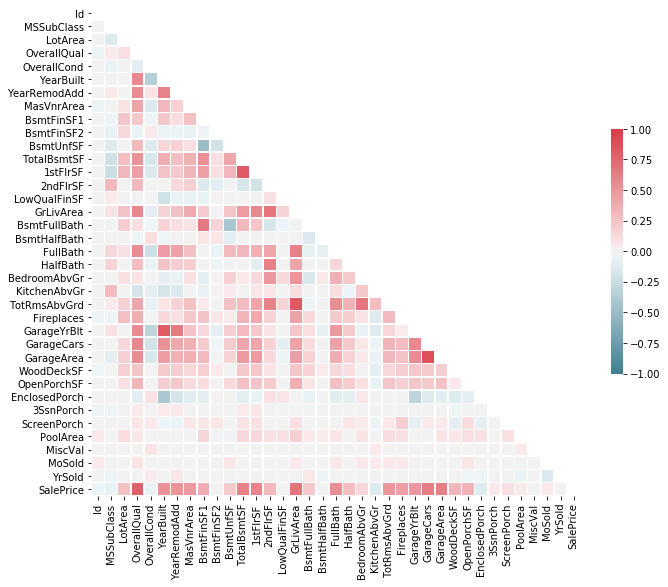

In [10]:
corr = train.corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [11]:
display(corr['SalePrice'].sort_values())

KitchenAbvGr    -0.130988
EnclosedPorch   -0.120705
OverallCond     -0.076170
MSSubClass      -0.072711
Id              -0.050353
YrSold          -0.023001
BsmtHalfBath    -0.014920
LowQualFinSF    -0.013572
BsmtFinSF2      -0.012884
MiscVal         -0.007514
PoolArea         0.042094
MoSold           0.051947
3SsnPorch        0.054625
ScreenPorch      0.102064
BedroomAbvGr     0.142972
BsmtUnfSF        0.216109
BsmtFullBath     0.224960
LotArea          0.258507
HalfBath         0.288938
2ndFlrSF         0.301083
WoodDeckSF       0.325967
OpenPorchSF      0.343693
BsmtFinSF1       0.374060
Fireplaces       0.448449
MasVnrArea       0.481373
GarageYrBlt      0.493368
TotRmsAbvGrd     0.505896
YearRemodAdd     0.508906
YearBuilt        0.522852
FullBath         0.547960
1stFlrSF         0.593785
TotalBsmtSF      0.601680
GarageArea       0.617562
GarageCars       0.628943
GrLivArea        0.682104
OverallQual      0.789174
SalePrice        1.000000
Name: SalePrice, dtype: float64

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 11 numerical features.

In [12]:
corr_sp = corr['SalePrice']
display(corr_sp)

print('')
columns_to_drop2 = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop)

train.drop(columns_to_drop2, inplace = True, axis = 1)
valid.drop(columns_to_drop2, inplace = True, axis = 1)
test.drop(columns_to_drop2, inplace = True, axis = 1)

display(train)
display(valid)
display(test)

Id              -0.050353
MSSubClass      -0.072711
LotArea          0.258507
OverallQual      0.789174
OverallCond     -0.076170
YearBuilt        0.522852
YearRemodAdd     0.508906
MasVnrArea       0.481373
BsmtFinSF1       0.374060
BsmtFinSF2      -0.012884
BsmtUnfSF        0.216109
TotalBsmtSF      0.601680
1stFlrSF         0.593785
2ndFlrSF         0.301083
LowQualFinSF    -0.013572
GrLivArea        0.682104
BsmtFullBath     0.224960
BsmtHalfBath    -0.014920
FullBath         0.547960
HalfBath         0.288938
BedroomAbvGr     0.142972
KitchenAbvGr    -0.130988
TotRmsAbvGrd     0.505896
Fireplaces       0.448449
GarageYrBlt      0.493368
GarageCars       0.628943
GarageArea       0.617562
WoodDeckSF       0.325967
OpenPorchSF      0.343693
EnclosedPorch   -0.120705
3SsnPorch        0.054625
ScreenPorch      0.102064
PoolArea         0.042094
MiscVal         -0.007514
MoSold           0.051947
YrSold          -0.023001
SalePrice        1.000000
Name: SalePrice, dtype: float64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
113,RL,Pave,Reg,Bnk,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,1953,1953,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,Gd,CBlock,Gd,TA,Mn,ALQ,Rec,1809,GasA,TA,Y,SBrkr,2259,2259,2,Gd,7,Typ,Basment,Unf,2,450,TA,TA,Y,COD,Abnorml,217000
7,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,TA,TA,CBlock,Gd,TA,Mn,ALQ,BLQ,1107,GasA,Ex,Y,SBrkr,1107,2090,2,TA,7,Typ,Attchd,RFn,2,484,TA,TA,Y,WD,Normal,200000
228,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,1967,1967,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,912,GasA,TA,Y,SBrkr,912,912,1,TA,5,Typ,Detchd,Unf,1,336,TA,TA,Y,WD,Normal,125000
650,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,Gd,TA,PConc,Gd,TA,No,Unf,Unf,813,GasA,Ex,Y,SBrkr,822,1665,2,Gd,7,Typ,Attchd,RFn,2,562,TA,TA,Y,WD,Normal,205950
859,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosA,Norm,1Fam,2Story,6,1968,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,Mn,BLQ,Unf,1054,GasA,TA,Y,SBrkr,1512,2654,2,Gd,9,Typ,Attchd,Unf,2,619,TA,TA,Y,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Unf,4,1956,1956,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,882,GasA,Ex,Y,SBrkr,882,882,1,TA,4,Typ,NaN,NaN,0,0,NaN,NaN,Y,WD,Normal,103200
1001,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,Fa,TA,No,Unf,Unf,691,GasA,Ex,Y,FuseA,691,691,1,Ex,4,Typ,Detchd,Unf,1,216,Fa,TA,N,WD,Abnorml,86000
567,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,7,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,1517,GasA,Ex,Y,SBrkr,1535,1535,2,Gd,7,Typ,Attchd,RFn,2,532,TA,TA,Y,WD,Normal,214000
23,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,1Story,5,1976,1976,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,1040,GasA,TA,Y,SBrkr,1060,1060,1,TA,6,Typ,Attchd,Unf,2,572,TA,TA,Y,WD,Normal,129900


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
98,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,ALQ,Unf,458,GasA,Fa,N,SBrkr,835,835,1,TA,5,Typ,Basment,Unf,1,366,Fa,TA,Y,COD,Abnorml,83000
1242,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,SFoyer,7,1974,1974,Gable,CompShg,Plywood,Plywood,BrkFace,TA,TA,CBlock,Gd,TA,Gd,GLQ,LwQ,1053,GasA,TA,Y,SBrkr,1173,1173,2,Gd,6,Typ,Attchd,RFn,2,528,TA,TA,Y,WD,Family,170000
1039,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,SFoyer,4,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,Gd,TA,Av,GLQ,Unf,630,GasA,TA,Y,SBrkr,630,630,1,TA,3,Typ,Attchd,Unf,1,286,TA,TA,Y,WD,Normal,80000
375,RL,Pave,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,Unf,683,GasA,Gd,N,FuseA,904,904,0,Fa,4,Maj1,NaN,NaN,0,0,NaN,NaN,Y,WD,Normal,61000
730,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,1595,GasA,Ex,Y,SBrkr,1616,1616,2,Gd,5,Typ,Attchd,RFn,2,608,TA,TA,Y,WD,Normal,236500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,1957,1957,Hip,CompShg,BrkFace,BrkFace,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,928,GasA,Gd,Y,FuseA,928,928,1,TA,5,Typ,Attchd,Fin,1,288,TA,TA,Y,WD,Normal,112500
793,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,2007,2007,Gable,CompShg,CemntBd,CmentBd,Stone,Gd,TA,PConc,Gd,TA,Av,Unf,Unf,1496,GasA,Ex,Y,SBrkr,1496,1496,2,Gd,7,Typ,Attchd,Fin,2,474,TA,TA,Y,New,Partial,225000
997,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,PosA,Norm,1Fam,1Story,6,1970,1970,Hip,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,1442,GasA,TA,Y,SBrkr,1442,1442,2,TA,6,Typ,Attchd,RFn,2,615,TA,TA,Y,WD,Normal,185000
1451,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,2008,2009,Gable,CompShg,CemntBd,CmentBd,Stone,Gd,TA,PConc,Gd,TA,No,Unf,Unf,1573,GasA,Ex,Y,SBrkr,1578,1578,2,Ex,7,Typ,Attchd,Fin,3,840,TA,TA,Y,New,Partial,287090


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,882.0,GasA,TA,Y,SBrkr,896,896,1,TA,5,Typ,Attchd,Unf,1.0,730.0,TA,TA,Y,WD,Normal
1,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,1329.0,GasA,TA,Y,SBrkr,1329,1329,1,Gd,6,Typ,Attchd,Unf,1.0,312.0,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,928.0,GasA,Gd,Y,SBrkr,928,1629,2,TA,6,Typ,Attchd,Fin,2.0,482.0,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,926.0,GasA,Ex,Y,SBrkr,926,1604,2,Gd,7,Typ,Attchd,Fin,2.0,470.0,TA,TA,Y,WD,Normal
4,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,1280.0,GasA,Ex,Y,SBrkr,1280,1280,2,Gd,5,Typ,Attchd,RFn,2.0,506.0,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,546.0,GasA,Gd,Y,SBrkr,546,1092,1,TA,5,Typ,NaN,NaN,0.0,0.0,NaN,NaN,Y,WD,Normal
1455,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,546.0,GasA,TA,Y,SBrkr,546,1092,1,TA,6,Typ,CarPort,Unf,1.0,286.0,TA,TA,Y,WD,Abnorml
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,1224.0,GasA,Ex,Y,SBrkr,1224,1224,1,TA,7,Typ,Detchd,Unf,2.0,576.0,TA,TA,Y,WD,Abnorml
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,912.0,GasA,TA,Y,SBrkr,970,970,1,TA,6,Typ,NaN,NaN,0.0,0.0,NaN,NaN,Y,WD,Normal


## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [13]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
113,RL,Pave,Reg,Bnk,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,Gd,CBlock,Gd,TA,Mn,ALQ,Rec,GasA,TA,Y,SBrkr,Gd,Typ,Basment,Unf,TA,TA,Y,COD,Abnorml
7,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,Stone,TA,TA,CBlock,Gd,TA,Mn,ALQ,BLQ,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
228,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Normal
650,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
859,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosA,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,Mn,BLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Unf,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,NaN,NaN,NaN,Y,WD,Normal
1001,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,Fa,TA,No,Unf,Unf,GasA,Ex,Y,FuseA,Ex,Typ,Detchd,Unf,Fa,TA,N,WD,Abnorml
567,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
23,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,1Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:
1.  LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [14]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [26]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
113,3.0,3,2,2,3,4.0,3.0,2.0,4.0,4.0,2,1,3.0,3,7,1.0,3.0,3.0,2
7,2.0,3,2,2,2,4.0,3.0,2.0,4.0,3.0,4,1,3.0,2,7,2.0,3.0,3.0,2
228,3.0,3,2,2,2,3.0,3.0,1.0,4.0,1.0,2,1,3.0,2,7,1.0,3.0,3.0,2
650,3.0,3,2,3,2,4.0,3.0,1.0,1.0,1.0,4,1,3.0,3,7,2.0,3.0,3.0,2
859,2.0,3,2,2,2,3.0,3.0,2.0,3.0,1.0,2,1,3.0,3,7,1.0,3.0,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,3.0,3,2,2,2,3.0,3.0,1.0,1.0,1.0,4,1,3.0,2,7,NaN,NaN,NaN,2
1001,3.0,3,2,2,2,2.0,3.0,1.0,1.0,1.0,4,1,2.0,4,7,1.0,2.0,3.0,0
567,2.0,3,2,3,2,4.0,3.0,1.0,5.0,1.0,4,1,3.0,3,7,2.0,3.0,3.0,2
23,3.0,3,2,2,2,4.0,3.0,1.0,5.0,1.0,2,1,3.0,2,7,1.0,3.0,3.0,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
98,3.0,3,2,2,2,3.0,3.0,1.0,4.0,1.0,1,0,3,2,7,1.0,2.0,3.0,2
1242,3.0,3,2,2,2,4.0,3.0,4.0,5.0,2.0,2,1,3,3,7,2.0,3.0,3.0,2
1039,3.0,3,2,2,2,4.0,3.0,3.0,5.0,1.0,2,1,3,2,7,1.0,3.0,3.0,2
375,2.0,3,0,1,1,2.0,1.0,4.0,3.0,1.0,3,0,2,1,3,NaN,NaN,NaN,2
730,2.0,3,2,3,2,4.0,3.0,1.0,5.0,1.0,4,1,3,3,7,2.0,3.0,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,3.0,3,2,2,2,3.0,3.0,1.0,4.0,1.0,3,1,2,2,7,3.0,3.0,3.0,2
793,3.0,3,2,3,2,4.0,3.0,3.0,1.0,1.0,4,1,3,3,7,3.0,3.0,3.0,2
997,2.0,3,2,2,2,3.0,3.0,1.0,1.0,1.0,2,1,3,2,7,2.0,3.0,3.0,2
1451,3.0,3,2,3,2,4.0,3.0,1.0,1.0,1.0,4,1,3,4,7,3.0,3.0,3.0,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
0,3.0,3.0,2,2,2,3.0,3.0,1.0,4.0,2.0,2,1,3,2.0,7.0,1.0,3.0,3.0,2
1,2.0,3.0,2,2,2,3.0,3.0,1.0,4.0,1.0,2,1,3,3.0,7.0,1.0,3.0,3.0,2
2,2.0,3.0,2,2,2,4.0,3.0,1.0,5.0,1.0,3,1,3,2.0,7.0,3.0,3.0,3.0,2
3,2.0,3.0,2,2,2,3.0,3.0,1.0,5.0,1.0,4,1,3,3.0,7.0,3.0,3.0,3.0,2
4,2.0,3.0,2,3,2,4.0,3.0,1.0,4.0,1.0,4,1,3,3.0,7.0,2.0,3.0,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.0,3.0,2,2,2,3.0,3.0,1.0,1.0,1.0,3,1,3,2.0,7.0,NaN,NaN,NaN,2
1455,3.0,3.0,2,2,2,3.0,3.0,1.0,4.0,1.0,2,1,3,2.0,7.0,1.0,3.0,3.0,2
1456,3.0,3.0,2,2,2,3.0,3.0,1.0,4.0,1.0,4,1,3,2.0,7.0,1.0,3.0,3.0,2
1457,3.0,3.0,2,2,2,4.0,3.0,3.0,5.0,1.0,2,1,3,2.0,7.0,NaN,NaN,NaN,2


Now that we've turned many of our categorical variables back into numerical ones, let's check the correlation coefficients again, but just for our updated features.

Ok, let's see what categorical features are left to deal with.

In [16]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
113,RL,Pave,Reg,Bnk,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,Gd,CBlock,Gd,TA,Mn,ALQ,Rec,GasA,TA,Y,SBrkr,Gd,Typ,Basment,Unf,TA,TA,Y,COD,Abnorml
7,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,Stone,TA,TA,CBlock,Gd,TA,Mn,ALQ,BLQ,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
228,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Normal
650,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
859,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosA,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,Mn,BLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Unf,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,NaN,NaN,NaN,Y,WD,Normal
1001,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,Fa,TA,No,Unf,Unf,GasA,Ex,Y,FuseA,Ex,Typ,Detchd,Unf,Fa,TA,N,WD,Abnorml
567,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
23,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,1Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models.

# Assessing our Results

Now that we've finished training one model from beginning to end, let's test it by uploading our results to Kaggle and see how we did.

# Developing a Pipeline

We went through a lot of steps to prepare our data and train our model. Let's condense as much of that as possible into a single pipeline that we can use for future datasets.

# Developing More Pipelines

This pipeline did ok, but surely we can do better if we tweak some of our steps. Let's develop some more pipelines from beginning to end, and compare the results of each.

# Comparing Models